# Chapter 18: Modern DCA for Unconventionals (RTA & Type Curves)
**Author:** Ade Anggi Naluriawan Santoso

**Objective:**
In this notebook, we will implement the foundations of **Rate Transient Analysis (RTA)** for shale reservoirs. We will calculate **Material Balance Time ($t_{mb}$)** and create a **Log-Log Diagnostic Plot** (Blasingame/Agarwal-Gardner style) to identify flow regimes.

**The Problem with Arps:**
* **Arps' Equation** applies only when the reservoir boundaries are felt (Boundary Dominated Flow - BDF).
* **Shale Wells:** Due to extremely low permeability (nanodarcies), they can stay in Transient Flow (Infinite Acting) for 5-10 years.
* **Consequence:** Using Arps too early results in a "b-factor" > 1, which predicts infinite reserves if not capped.

**The Solution (Material Balance Time):**
Modern RTA replaces physical time ($t$) with Material Balance Time ($t_{mb}$):
$$t_{mb} = \frac{N_p(t)}{q(t)}$$

When we plot **Rate ($q$)** vs **$t_{mb}$** on a **Log-Log scale**:
1.  **Transient Flow:** Appears as a straight line with slope **-0.5** (Linear Flow in fractures).
2.  **Boundary Dominated Flow:** Appears as a straight line with slope **-1.0** (Unit slope).

This allows us to visually "match" the well's performance against Type Curves.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 7)

# --- 1. GENERATE SYNTHETIC SHALE PRODUCTION ---
# We will simulate a well with:
# - 2 Years of Linear Flow (Transient) -> Slope -0.5
# - Followed by Boundary Dominated Flow -> Slope -1.0

t_days = np.arange(1, 2000, 5) # 5.5 years history

# Model: q = C * t^(-0.5) for early time
qi = 1000
q_transient = qi * (t_days ** -0.5)

# Force a transition to boundary flow at Day 730 (Year 2)
# After Day 730, decline speeds up (Arps b=0 exponential-ish relative to t_mb)
# For simplicity in synthesis, we'll just switch equations
idx_switch = np.searchsorted(t_days, 730)

q_shale = np.zeros_like(q_transient)
q_shale[:idx_switch] = q_transient[:idx_switch]

# Exponential decline tail starting from the switch point rate
q_switch = q_transient[idx_switch]
t_switch = t_days[idx_switch]
D_bound = 0.001 # Decline rate for boundary phase
q_shale[idx_switch:] = q_switch * np.exp(-D_bound * (t_days[idx_switch:] - t_switch))

# Add some noise (Field Data is messy!)
noise = np.random.normal(0, 0.05, len(t_days)) # 5% noise
q_final = q_shale * (1 + noise)

df_shale = pd.DataFrame({'Time': t_days, 'Rate': q_final})

# Calculate Cumulative Production (Np)
# Integration using trapezoidal rule
df_shale['Np'] = np.concatenate([[0], np.cumsum((q_final[:-1] + q_final[1:]) / 2 * np.diff(t_days))])

print("--- Shale Well Production Data ---")
print(df_shale.head())

--- Shale Well Production Data ---
   Time         Rate           Np
0     1  1008.467846     0.000000
1     6   417.246716  3564.286406
2    11   307.106271  5375.168874
3    16   237.239510  6736.033325
4    21   223.163162  7887.040004


## 1. Calculating Material Balance Time ($t_{mb}$)

This is the most critical transformation in modern RTA. It "linearizes" the boundary dominated flow regime, making it look like a harmonic decline ($b=1$) regardless of the actual drive mechanism.

$$t_{mb} = \frac{\text{Cumulative Production}}{\text{Instantaneous Rate}} = \frac{N_p}{q}$$

In [2]:
# Calculate Material Balance Time
# Avoid division by zero for the first point
df_shale['t_mb'] = df_shale['Np'] / df_shale['Rate']

# Clean up any NaNs or Infs (first point might be 0/0 or 0/Rate)
df_shale = df_shale.replace([np.inf, -np.inf], np.nan).dropna()

print(df_shale[['Time', 'Rate', 'Np', 't_mb']].head())

   Time         Rate           Np       t_mb
0     1  1008.467846     0.000000   0.000000
1     6   417.246716  3564.286406   8.542395
2    11   307.106271  5375.168874  17.502635
3    16   237.239510  6736.033325  28.393387
4    21   223.163162  7887.040004  35.342034


## 2. Generating Type Curves (The "Stems")

To perform a "Match," we compare our data against theoretical curves. The most common are the **Fetkovich/Arps Type Curves** plotted against $t_{mb}$.

The theoretical equation for the boundary-dominated stems (on $t_{mb}$ basis) is:
$$q_{Dd} = \frac{1}{1 + t_{Dd}}$$
*(Note: On a $t_{mb}$ plot, ALL Arps curves collapse into this single harmonic stem during depletion. This is the power of the method!)*

However, the **Transient** part differs.
* **Vertical Well (Radial):** Line with slope approx 0 (on standard Fetkovich).
* **Horizontal Frac (Linear):** Line with slope -0.5.

In [3]:
def generate_type_curves():
    """
    Generates theoretical curves for visualization background.
    """
    t_dim = np.logspace(-2, 4, 100) # Dimensionless Material Balance Time
    
    # Stem 1: Linear Flow (The "Half Slope" line) typical for fractured shale
    # q_D ~ t_D ^ -0.5
    # We arbitrarily position it for visualization
    q_D_linear = 1.0 * (t_dim ** -0.5)
    
    # Stem 2: Boundary Dominated Flow (The "Unit Slope" line)
    # q_D ~ 1 / t_D (Harmonic decline on t_mb plot)
    q_D_bdf = 1.0 / t_dim
    
    # Stem 3: The Combined Harmonic Reference Curve (Agarwal-Gardner style)
    # qD = 1 / (1 + tD)
    q_D_harmonic = 1 / (1 + t_dim)
    
    return t_dim, q_D_linear, q_D_bdf, q_D_harmonic

# Generate
td_ref, qd_lin, qd_bdf, qd_harm = generate_type_curves()

## 3. The Diagnostic Plot (Log-Log)

We will plot:
1.  **Production Data:** Rate vs. $t_{mb}$ (Log-Log).
2.  **Diagnostic Lines:**
    * **Slope -0.5 Line:** Indicates Linear Flow (fracture drainage).
    * **Slope -1.0 Line:** Indicates Boundary Dominated Flow (tank depletion).

**Matching Procedure:**
In commercial software (like IHS Harmony or Kappa Citrine), you would slide the data points horizontally and vertically until they overlay the type curve. Here, we will plot them to observe the **Flow Regimes**.

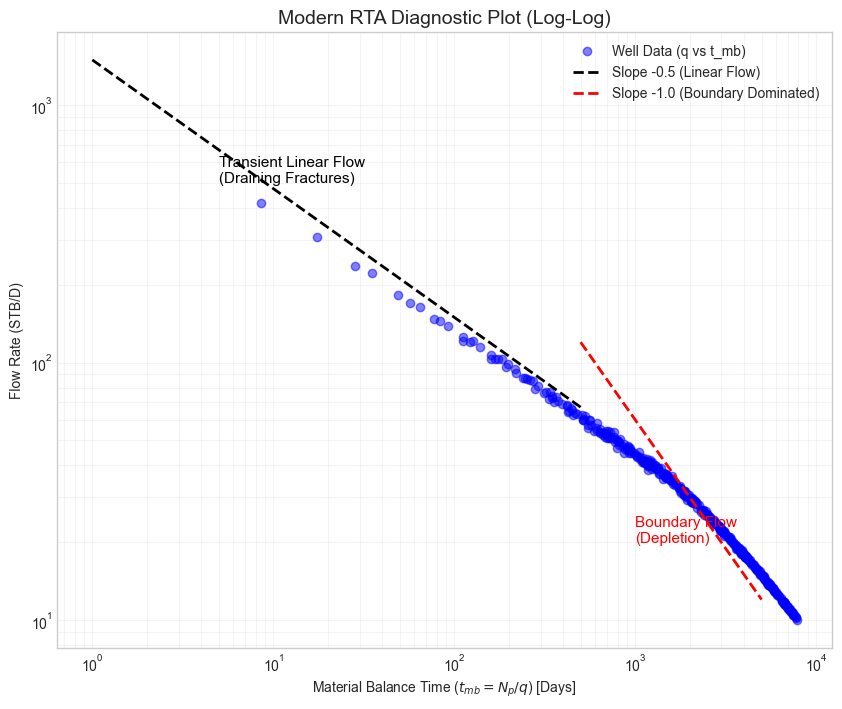

In [4]:
fig, ax = plt.subplots(figsize=(10, 8))

# 1. Plot Well Data
# We plot q vs t_mb
ax.loglog(df_shale['t_mb'], df_shale['Rate'], 'bo', alpha=0.5, label='Well Data (q vs t_mb)')

# 2. Add Diagnostic Slopes (Visual Guides)
# We manually place these "sticks" near the data to show the slope match

# Guide 1: Half-Slope (Linear Flow) - The "Fingerprint" of Shale
# Arbitrary intercept chosen to sit near the early data
x_guide1 = np.linspace(1, 500, 10)
y_guide1 = 1500 * (x_guide1 ** -0.5) 
ax.plot(x_guide1, y_guide1, 'k--', linewidth=2, label='Slope -0.5 (Linear Flow)')

# Guide 2: Unit-Slope (BDF) - The "Tank" signal
# Arbitrary intercept chosen to sit near the late data
x_guide2 = np.linspace(500, 5000, 10)
y_guide2 = 60000 * (x_guide2 ** -1.0) 
ax.plot(x_guide2, y_guide2, 'r--', linewidth=2, label='Slope -1.0 (Boundary Dominated)')

# Annotations
ax.set_title('Modern RTA Diagnostic Plot (Log-Log)', fontsize=14)
ax.set_xlabel('Material Balance Time ($t_{mb} = N_p/q$) [Days]')
ax.set_ylabel('Flow Rate (STB/D)')
ax.legend()
ax.grid(True, which="both", ls="-", alpha=0.2)

# Text Explanations
ax.text(5, 500, 'Transient Linear Flow\n(Draining Fractures)', color='black', fontsize=11)
ax.text(1000, 20, 'Boundary Flow\n(Depletion)', color='red', fontsize=11)



plt.show()

## Conclusion

This diagnostic plot reveals the life story of the well:

1.  **Early Time ($t_{mb} < 700$):** The data aligns perfectly with the **-0.5 Slope**. This confirms the well is in **Linear Flow**, producing primarily from the induced fracture network.
2.  **Late Time ($t_{mb} > 700$):** The data bends down and approaches the **-1.0 Slope**. This indicates the well has "felt the boundaries" (interference between fractures or neighboring wells) and is now depleting the stimulated volume.

**Why this matters:**
If you fit an Arps curve during the "Linear Flow" phase, you would get a $b$-value of 2.0 (unbounded). By identifying the transition to the "Unit Slope," we know we must switch to a conservative decline ($b \to 0$) to calculate EUR correctly.